# Setup

In [142]:
import scipy
import math
import numpy as np
from diagonalize import State, delta, neg_1_pow, Interaction, Molecule
import matplotlib.pyplot as pyplot

In [143]:
int_wigner_arr = np.load("wigner3j_integer_N=10.npy")
halfint_wigner_arr = np.load("wigner3j_halfint_N=3.5.npy")

def T_int(n3, n1, m3, m1, n2, m2, N=10):
    m1_ = m1 + N
    m2_ = m2 + 2
    m3_ = m3 + N
    
    return m2_ + 5*n2 + 15*m1_ + (15 + 30*N)*m3_ + (15+ 60*N + 60*N*N)*n1 + (15 + 75*N + 120*N*N + 60 *N*N*N)*n3

def T_half_int(n3, n1, m3, m1, n2, m2, N = 7/2):
    n3 = n3 - 0.5 # 1/2, 3/2, 5/2, 7/2 -> 0, 1, 2, 3 (max is (N - 0.5))
    n1 = n1 - 0.5 # 1/2, 3/2, 5/2, 7/2 -> 0, 1, 2, 3 (max is (N - 0.5))
    
    n2 = n2 # 0, 1, 2 (max is 2)
    m2 = m2 + 2 # -2, -1, 0, 1, 2 -> 0, 1, 2, 3, 4 (max is 4)
    
    m3 = m3 + N # -7/2, -5/2, -3/2, -1/2, 1/2, 3/2, 5/2, 7/2 -> 0, 1, 2, 3, 4, 5, 6, 7 (max is N*2)
    m1 = m1 + N # -7/2, -5/2, -3/2, -1/2, 1/2, 3/2, 5/2, 7/2 -> 0, 1, 2, 3, 4, 5, 6, 7 (max is N*2)
    
    # max: (4)    (4)+(2*5)    (4+2*5)+(15*N*2)    (4+2*5+15*N*2)+(15+30*N)*N*2   (4+2*5+15*N*2)+(15+30*N)*N*2 + (15+60*N+60*N*N)*(N-0.5)
    return int(m2     + 5 * n2         + 15 * m1               + (15+30*N)*m3  + (15+60*N+60*N*N)*n1     + (60*N*N*N + 90*N*N + 45*N + 7.5)*n3)
    
def wigner_3j(n1, n2, n3, m1, m2, m3):
    if n1 == int(n1):
        return int_wigner_arr[T_int(n3,n1,m3,m1,n2,m2)]
    return halfint_wigner_arr[T_half_int(n3,n1,m3,m1,n2,m2)]
    

In [144]:
h = scipy.constants.h
muN = scipy.constants.physical_constants['nuclear magneton'][0]
bohr = scipy.constants.physical_constants['Bohr radius'][0]
eps0 = scipy.constants.epsilon_0
c = scipy.constants.c
DebyeSI = 3.33564e-30

Na23Cs133 = {"I1":1.5,
            "I2":3.5,
            "g1":1.478,
            "g2":0.738,
            "d0":4.69*DebyeSI,
            "Brot":0.058*c*100*h,
            "Drot":0*h,
            "Q1":-0.097e6*h,
            "Q2":0.150e6*h,
            "C1":14.2*h,
            "C2":854.5*h,
            "C3":105.6*h,
            "C4":3941.8*h,
            "MuN":0*muN,
            "Mu1":1.478*muN,
            "Mu2":0.738*muN,
            "a0":0*h, #Not reported
            "a2":0*h, #Not reported
            "Beta":0}

def rotational(state1: State, state2:State):
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()

    if delta(n, n_) and delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_):
        return n*(n+1)
    return 0

def centrifugal(state1: State, state2:State):
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()

    if delta(n, n_) and delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_):
        return -n*(n+1)**2
    return 0

def quad_Na(state1: State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not delta(m2, m2_):
        return 0
    
    sum_term = 0
    for p in range(-2,3):
        wigp1 = wigner_3j(n, 2, n_, -mn, p, mn_)
        wigp2 = wigner_3j(i1, 2, i1, -m1, -p, m1_)
        sum_term += neg_1_pow(p) * wigp1 * wigp2
    
    if sum_term == 0:
        return 0 
        
    wig3 = wigner_3j(n, 2, n_, 0, 0, 0)
    if wig3 == 0:
        return 0

    wig4 = wigner_3j(i1, 2, i1, -i1, 0, i1)
    if wig4 == 0:
        raise("ArithmeticError; wigner coefficient is 0 but must be inverted")
    wig4 = 1.0/wig4
    
    other = neg_1_pow(-mn+i1-m1)*math.sqrt((2*n + 1) * (2*n_ + 1))/4

    return sum_term * wig3 * wig4 * other

def quad_Cs(state1:State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not delta(m1, m1_):
        return 0
    
    sum_term = 0
    for p in range(-2,3):
        wigp1 = wigner_3j(n, 2, n_, -mn, p, mn_)
        wigp2 = wigner_3j(i2, 2, i2, -m2, -p, m2_)
        sum_term += neg_1_pow(p) * wigp1 * wigp2
    
    if sum_term == 0:
        return 0 
        
    wig3 = wigner_3j(n, 2, n_, 0, 0, 0)
    if wig3 == 0:
        return 0

    wig4 = wigner_3j(i2, 2, i2, -i2, 0, i2)
    if wig4 == 0:
        raise("ArithmeticError; wigner coefficient is 0 but must be inverted")
    wig4 = 1.0/wig4
    
    other = neg_1_pow(-mn+i2-m2)*math.sqrt((2*n + 1) * (2*n_ + 1))/4

    return sum_term * wig3 * wig4 * other

def spin_rot_Na(state1:State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(n, n_) and delta(m2, m2_)):
        return 0
    
    sum_term = 0
    for p in range(-1,2):
        wigp1 = wigner_3j(n, 1, n, mn, p, -mn_)
        wigp2 = wigner_3j(i1, 1, i1, m1, -p, -m1_)
        sum_term += wigp1 * wigp2 * neg_1_pow(p)
       
    if sum_term == 0:
        return 0
        
    other = neg_1_pow(n+mn_+i1+m1_) * math.sqrt(n * (n + 1) * (2*n + 1) * i1 * (i1 + 1) * (2*i1 + 1))
    if other == 0:
        return 0 

    return sum_term * other

def spin_rot_Cs(state1:State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(n, n_) and delta(m1, m1_)):
        return 0
    
    other = neg_1_pow(n+mn_+i2+m2_) * math.sqrt(n * (n + 1) * (2*n + 1) * i2 * (i2 + 1) * (2*i2 + 1))
    if other == 0:
        return 0 
    
    sum_term = 0
    for p in range(-1,2):
        wigp1 = wigner_3j(n, 1, n, mn, p, -mn_)
        wigp2 = wigner_3j(i2, 1, i2, m2, -p, -m2_)
        sum_term += wigp1 * wigp2 * neg_1_pow(p)
    
    if sum_term == 0:
        return 0

    return sum_term * other

def nuc_spin_spin(state1: State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(n, n_) and delta(mn, mn_)):
        return 0
    
    other = neg_1_pow(i1+m1_+i2+m2_) * math.sqrt(i1 * (i1 + 1) * (2*i1 + 1) * i2 * (i2 + 1) * (2*i2 + 1))
    
    sum_term = 0
    for p in range(-1,2):
        wigp1 = wigner_3j(i1, 1, i1, m1, p, -m1_)
        wigp2 = wigner_3j(i2, 1, i2, m2, -p, -m2_)
        sum_term += wigp1 * wigp2 * neg_1_pow(p)
    
    if sum_term == 0:
        return 0

    return sum_term * other

def nuc_spin_spin_dip(state1: State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    sqrtpart = -math.sqrt(30 * i1 * (i1 + 1) * (2*i1 + 1) * i2 * (i2 + 1) * (2*i2 + 1) * (2*n + 1) * (2*n_ + 1))
    
    negpart = neg_1_pow(i1 + i1 - m1 - m2 - mn)
    
    wig0 = wigner_3j(n, 2, n_, 0, 0, 0)
    
    sum = 0
    
    for p in range(-1,2):
        wig1 = wigner_3j(i2, 1, i2, -m2, -p, m2)
        
        for p1 in range(-1,2):
            for p2 in range(-1,2):
                
                wig2 = wigner_3j(n, 1, n_, -mn, p1, mn_)
                wig3 = wigner_3j(i1, 1, i1, -m1, p2, m1_)
                wig4 = wigner_3j(1, 2, 1, p1, p2, -p)
        sum += wig1 * wig2 * wig3 * wig4
        
    if sum == 0:
        return 0
    
    return sqrtpart * negpart * wig0 * sum

def stark(state1: State, state2:State):
    
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_)):
        return 0
    
    wig1 = wigner_3j(n, 1, n_, -mn, 0, mn)
    if wig1 == 0:
        return 0
    
    wig2 = wigner_3j(n, 1, n_, 0, 0, 0)
    if wig2 == 0:
        return 0
    
    other = -neg_1_pow(mn+m1+m2) * math.sqrt((2*n + 1) * (2*n_ + 1))
    #print(state1,state2, other)
    
    return wig1 * wig2 * other

    

# Molecule Initialization

In [145]:
from scipy.constants import physical_constants
from scipy.constants import c
from scipy.constants import epsilon_0

int_rotational = Interaction(Na23Cs133["Brot"], rotational)
int_centrifugal = Interaction(Na23Cs133["Drot"], centrifugal)
int_quad_na = Interaction(Na23Cs133["Q1"], quad_Na)
int_quad_cs = Interaction(Na23Cs133["Q2"], quad_Cs)

const_nuc_spin_spin_dip = Na23Cs133["g1"] * Na23Cs133["g2"] * physical_constants["nuclear magneton"][0]**2 / (4 * math.pi * epsilon_0 * c * c)
int_nuc_spin_spin_dip = Interaction(const_nuc_spin_spin_dip, nuc_spin_spin_dip)
int_nuc_spin_spin = Interaction(Na23Cs133["C4"], nuc_spin_spin)
int_spin_rot_Na = Interaction(Na23Cs133["C1"], spin_rot_Na)
int_spin_rot_Cs = Interaction(Na23Cs133["C2"], spin_rot_Cs)
int_stark = Interaction(Na23Cs133["d0"], stark)

In [146]:
NaCs = Molecule([0,1,2,3,4,5], 3/2, 7/2)

NaCs.add_interaction(int_rotational)
#NaCs.add_interaction(int_centrifugal)
NaCs.add_interaction(int_quad_na)
NaCs.add_interaction(int_quad_cs)
NaCs.add_interaction(int_nuc_spin_spin)
NaCs.add_interaction(int_nuc_spin_spin_dip)
NaCs.add_interaction(int_spin_rot_Na)
NaCs.add_interaction(int_spin_rot_Cs)
NaCs.add_changing_interaction(int_stark)

H has dim 1152


In [147]:
NaCs.find_H_zero()
NaCs.find_H_prime()

E_range = np.linspace(0, 10, int(60)) * 1e5
eigenvalues_and_eigenvectors = NaCs.compute_eigenval_over_range([E_range])
eigenvalues_to_plot = []
for elem in eigenvalues_and_eigenvectors:
    eigenvalues_to_plot.append(np.sort(elem[0].copy())[:])
myenergies = np.array(eigenvalues_to_plot)

In [192]:
print("Electric field values ct:", len(eigenvalues_and_eigenvectors), "\nEigenvalue/Eigenvector tuples count", len(eigenvalues_and_eigenvectors[0][0]))

Electric field values ct: 60 
Eigenvalue/Eigenvector tuples count 1152


# Eigenvectors of the appropriate states for a quantum gate

First, let's chose certain electric field values in the range of our electric field strengths. We select these to be large enough to ensure pendular states, but at the same time different enough from each other so that the states $\ket{0 1}$ and $\ket{1 0}$ are distinguishable.

In [188]:
print("State a is at E =", E_range[35], "kV/cm")
print("State b is at E =", E_range[59], "kV/cm")

State a is at E = 593220.3389830509 kV/cm
State b is at E = 1000000.0 kV/cm


Now, let's ensure that the eigenvalues are in an appropriate order, for these particular field strengths.

In [156]:
valuesa, vectorsa = eigenvalues_and_eigenvectors[35]
prevval = -100000000
for value in valuesa:
    if value < prevval:
        print("ordering error")
    prevval = value

valuesb, vectorsb = eigenvalues_and_eigenvectors[59]
prevval = -100000000
for value in valuesb:
    if value < prevval:
        print("ordering error")
    prevval = value

Ok, they are in order. Now, we can find the eigenvectors corresponding to **n=0 and n=1**. Those are the ones with eigenvalues less than **7000 MHz**. We start by counting how many such eigenvectors there are.

In [157]:
counteigenveca = 0
for value in valuesa:
    if value*1e-6/h < 4000:
        counteigenveca += 1
print("a", counteigenveca)

counteigenvecb = 0
for value in valuesb:
    if value*1e-6/h < 4000:
        counteigenvecb += 1
print("b", counteigenvecb)

a 128
b 128


There are **128** such eigenvectors; as the eigenvalues are all in order, they are just the first **128** eigenvectors in the respective eigenvector arrays above. But now it is important to differentiate what is $\ket{0}_a$ and $\ket{1}_a$ and same for $\ket{0}_b$ and $\ket{1}_b$. We will do taking note of the boundaries observed on the following plot.

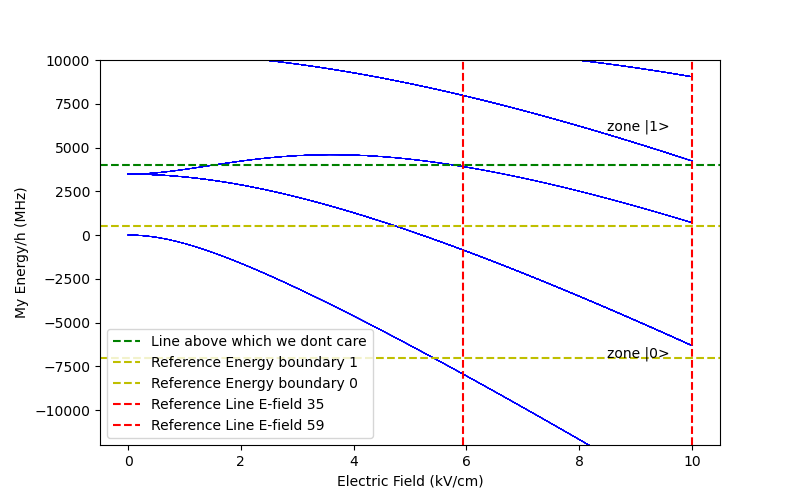

In [167]:
%matplotlib ipympl

pyplot.close()

fig, ax = pyplot.subplots(figsize=(8, 5))

ax.plot(E_range*1e-5, myenergies[:,:]*1e-6/h, color='b', linewidth=0.5)
ax.set_ylim(-12000, 10000)

ax.axhline(y=4000, color='g', linestyle='--', label='Line above which we dont care')
ax.axhline(y=500, color='y', linestyle='--', label='Reference Energy boundary 1')
ax.axhline(y=-7000, color='y', linestyle='--', label='Reference Energy boundary 0')

ax.axvline(x=E_range[35]*1e-5, color='r', linestyle='--', label='Reference Line E-field 35')
ax.axvline(x=E_range[59]*1e-5, color='r', linestyle='--', label='Reference Line E-field 59')

ax.text(8.5, 6000, "zone |1>")
ax.text(8.5, -7000, "zone |0>")

ax.set_ylabel("My Energy/h (MHz)")
ax.set_xlabel("Electric Field (kV/cm)")

ax.legend()

Note that for a large dipole-dipole interaction, we want a large difference in $\frac{dE}{dF}$ between the different states $\ket{0}$ $\ket{1}$. I have no clue why; **this needs citation and understanding**, but Jesus told me so. So we don't really care about the line in between reference lines $0$ and $1$. 

Now, let's actually get those states! We need to start by counting...

In [168]:
counteigenvec_0_a = 0

for val in valuesa:
    if val*1e-6/h < -7000:
        counteigenvec_0_a += 1
print(counteigenvec_0_a)

counteigenvec_0_b = 0

for val in valuesb:
    if val*1e-6/h < -7000:
        counteigenvec_0_b += 1
print(counteigenvec_0_b)

32
32


In [172]:
counteigenvec_1_a = 0

for val in valuesa:
    if val*1e-6/h < 500:
        counteigenvec_1_a += 1
print(counteigenvec_1_a)

counteigenvec_1_b = 0

for val in valuesb:
    if val*1e-6/h < 500:
        counteigenvec_1_b += 1
print(counteigenvec_1_b)

96
96


To recount these counts (lol), eigenvectors $0$ through $31$ (inclusive) will correspond to $\ket{0}$ and those from $96$ through $127$ (inclusive) will correspond to $\ket{1}$. Now we can just make all the arrays necessary for future analysis.

In [179]:
states_0_a = vectorsa[:32]
energies_0_a = valuesa[:32]

states_0_b = vectorsb[:32]
energies_0_b = valuesb[:32]

states_1_a = vectorsa[96:128]
energies_1_a = valuesa[96:128]

states_1_b = vectorsb[96:128]
energies_1_b = valuesb[96:128]

In [184]:
print("State |0>b is", energies_0_b[0]*1e-6/h, "MHz")

print("State |0>a is", energies_0_a[0]*1e-6/h, "MHz")

print("State |1>b is", energies_1_b[0]*1e-6/h, "MHz")

print("State |1>a is", energies_1_a[0]*1e-6/h, "MHz")

State |0>b is -15442.897558926492 MHz
State |0>a is -7930.790746624561 MHz
State |1>b is 707.5208040686215 MHz
State |1>a is 3915.177797673826 MHz


In [171]:
def dipole_dipole(statea : State, statea_ : State, stateb : State, stateb_ : State):
    na, mna, m1a, m2a  = statea.get_state_vector()
    na_, mna_, m1a_, m2a_  = statea_.get_state_vector()
    nb, mnb, m1b, m2b  = stateb.get_state_vector()
    nb_, mnb_, m1b_, m2b_  = stateb_.get_state_vector()
    
    deltapart = delta(m1a, m1a_) * deltapart(m2a, m2a_) * delta(m1b, m1b_) * deltapart(m2b, m2b_)
    if deltapart == 0:
        return 0

    wig0 = wigner_3j(na_, 1, na, 0, 0, 0)
    if wig0 == 0:
        return 0
    wig1 = wigner_3j(na_, 1, na, mna_, 0, mna)
    if wig1 == 0:
        return 0
    wig2 = wigner_3j(nb_, 1, nb, 0, 0, 0)
    if wig2 == 0:
        return 0
    wig3 = wigner_3j(nb_, 1, nb, mnb_, 0, mnb)
    if wig3 == 0:
        return 0
    
    sqrtpart = np.sqrt((2*na + 1) * (2*na_+1) * (2*nb+1) * (2*nb_+1))
    
    return wig0 * wig1 * wig2 * wig3 * sqrtpart    

In [196]:
# takes a minute thirty to run 1/1000
ct = 0
for i in range(1000**4):
    if ct % 1000000000 == 0:
        print("check")
    ct +=1

check
check


KeyboardInterrupt: 

In [ ]:
def compute_dipole_dipole(eigenvec1, eigenvec2, basisStates):
    V_dd = 0
    for ia, statea_ in enumerate(basisStates):
        for ib, stateb_ in enumerate(basisStates):
            for ja, statea in enumerate(basisStates):
                for jb, statea in enumerate(basisStates):
                    